## 1 线性回归

In [1]:
import torch
from time import time

print(torch.__version__)

1.3.1


### 1.1 矢量计算表达式

In [4]:
a = torch.ones(10000)
b = torch.ones(10000)
# 标量计算
start = time()
c = torch.zeros(10000)
for i in range(10000):
    c[i] = a[i] + b[i]
print(time() - start)

# 矢量运算
start = time()
d = a + b
print(time() - start)

0.13170099258422852
9.775161743164062e-05


对于线性回归$\hat{\vec{y}} = X\vec{w} + b$，其中$b$本应是矢量，但这里写成标量即可。因为torch会自动触发广播机制。

In [5]:
a = torch.ones(3)
b = 1
print(a + b)

tensor([2., 2., 2.])


### 1.2 从零开始实现线性回归

In [6]:
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random
%matplotlib inline

#### 1.2.1 手动生成数据集
根据真实权重$\vec{w} = [2, -3.4]^\top$，真实偏差$b = 4.2$，以及一个随机噪声项$\epsilon$生成1000个样本标签$y$：
$$
\vec{y} = X \vec{w} + b + \epsilon,
$$
其中$\epsilon$服从$\mathcal{N}(\mu=0, \sigma^2=0.01)$。

In [7]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.randn(num_examples, num_inputs, dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float32)

观察$w_2$和label之间的关系。在此之前先对matplotlib进行一些设置。

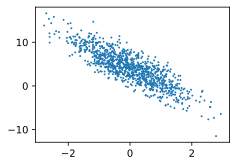

In [8]:
# --------utils--------
def use_svg_display():
    display.set_matplotlib_formats('svg')

# --------utils--------
def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

# 绘制散点图观察关系
set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1)

#### 1.2.2 读取mini-batch数据

In [9]:
def get_mini_batch_data(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        # 最后一个batch可能不足batch_size个样本
        selected_indices = torch.LongTensor(indices[i: min(i+batch_size, num_examples)])
        yield features.index_select(0, selected_indices), labels.index_select(0, selected_indices)

观察第一个min-batch中的样本：

In [10]:
for X, y in get_mini_batch_data(10, features, labels):
    print(X, '\n', y)
    break

tensor([[-2.4501, -1.1373],
        [-0.1316,  0.9561],
        [-0.9024, -0.1697],
        [-1.3989,  1.1945],
        [ 0.3933,  0.2469],
        [ 0.4060,  0.3341],
        [ 0.0580,  0.0709],
        [-0.1448, -1.7756],
        [-1.6474,  2.3168],
        [ 3.0277, -0.3424]]) 
 tensor([ 3.1542,  0.6750,  2.9546, -2.6625,  4.1343,  3.8726,  4.0692,  9.9481,
        -6.9656, 11.4110])


#### 1.2.3 初始化模型参数

In [23]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32, requires_grad=True)
b = torch.zeros(1, dtype=torch.float32, requires_grad=True)

#### 1.2.4 定义线性回归模型

In [25]:
def linreg(X, w, b):
    # torch matrix multiply and broadcast
    return torch.mm(X, w) + b

#### 1.2.5 定义均方误差损失函数

In [26]:
def squared_loss(y_hat, y):
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

#### 1.2.6 Mini-batch梯度下降算法
设$\vec{\theta} = (\vec{w}, b)$，则MGD的迭代步骤为：
$$
\vec{\theta} \leftarrow \vec{\theta} - \frac{\eta}{|\mathcal{B}|} 
\sum_{i \in \mathcal{B}} \nabla_{\theta} l^{(i)} (\theta),
$$
具体地，
$$
k=1, 2: w_k \leftarrow w_k - \frac{\eta}{|\mathcal{B}|} 
\sum_{i \in \mathcal{B}} x_k^{(i)} \Big( [\vec{x}^{(i)}]^\top \vec{w} + b - y^{(i)} \Big),
$$
$$
b \leftarrow b - \frac{\eta}{|\mathcal{B}|} 
\sum_{i \in \mathcal{B}} \Big( [\vec{x}^{(i)}]^\top \vec{w} + b - y^{(i)} \Big).
$$
当然，梯度部分$\nabla_{\theta} l^{(i)} (\theta)$全权交给torch即可。只需要调用``.grad``即可获得梯度。

In [35]:
def mgd(params, lr, batch_size):
    """
    Mini-batch Gradient Desecnt.
    """
    for param in params:
        param.data -= lr * param.grad / batch_size

#### 1.2.7 训练模型
注意均方误差函数返回的是一个矢量，大小为$\mathbb{R}^{|\mathcal{B}|}$。一种简单的方式是对均方误差函数返回的矢量求和（即$\vec{1}^\top \vec{l}$），这样既转换成了标量，也不违背MGD的迭代过程。

In [36]:
lr = 0.03
num_epochs = 3
batch_size = 10

for epoch in range(num_epochs):
    # 一个epoch中，每个样本会被使用一次
    for X, y in get_mini_batch_data(batch_size=batch_size, features=features, labels=labels):
        # 求和变标量
        l = squared_loss(linreg(X, w, b), y).sum()
        # 计算梯度并根据MGD更新参数
        l.backward()
        mgd([w, b], lr, batch_size)
        # 梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = squared_loss(linreg(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.029724
epoch 2, loss 0.000127
epoch 3, loss 0.000050


对比训练结果和参数真值：

In [37]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 1.9993],
        [-3.3993]], requires_grad=True)
4.2 
 tensor([4.2000], requires_grad=True)


### 1.3 线性回归的PyTorch实现

数据集生成沿用章节1.2.1的内容。

#### 1.3.1 读取数据

In [11]:
import torch.utils.data as Data

batch_size = 10
# 直接调用工具生成数据集
dataset = Data.TensorDataset(features, labels)
# 直接调用工具获取mini-batch data（num_workers指定了线程数）
get_mini_batch_data = Data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=2)

for X, y in get_mini_batch_data:
    print(X, '\n', y)
    break

tensor([[-0.6880,  0.4885],
        [ 0.9498, -0.4866],
        [-0.3896,  0.0637],
        [-0.9580,  1.0612],
        [ 1.2808, -0.6951],
        [-0.8609,  0.0390],
        [-1.1445, -0.0970],
        [-0.1547, -0.6309],
        [ 0.1105, -0.8169],
        [-0.2967,  0.4519]]) 
 tensor([ 1.1544,  7.7555,  3.2035, -1.3224,  9.1377,  2.3316,  2.2343,  6.0409,
         7.1944,  2.0606])


#### 1.3.2 定义线性回归模型
PyTorch提供了大量预定义的层，这使得我们只需关注使用哪些层来构造模型。``torch.nn``的核心数据结构是``Module``，它是一个抽象概念，既可以表示神经网络中的某个层（layer），也可以表示一个包含很多层的神经网络。在实际使用中，最常见的做法是继承``nn.Module``，撰写自己的网络/层。

线性回归可视为仅包含单个网络层（全连接输出层）的神经网络。

In [12]:
import torch.nn as nn
class LinearNet(nn.Module):
    def __init__(self, in_features):
        """
        在init中定义网络结构。
        """
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(in_features, 1)
    def forward(self, x):
        """
        在forward中定义inference过程。
        """
        y = self.linear(x)
        return y
net = LinearNet(num_inputs)
print(net)

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


还可以使用``nn.Sequential``更方便地搭建模型。``Sequential``是一个有序的容器，网络层将按照在传入``Sequential``的顺序依次被添加到计算图中。下面列出了三种写法。

In [15]:
net = nn.Sequential(
    nn.Linear(num_inputs, 1)
    # add more modules
)
print(net)
print(net[0])

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


In [16]:
net = nn.Sequential()
net.add_module('linear', nn.Linear(num_inputs, 1))
# add more modules
print(net)
print(net[0])

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


In [17]:
from collections import OrderedDict
net = nn.Sequential(OrderedDict([
    ('linear', nn.Linear(num_inputs, 1))
    # add more modules
]))
print(net)
print(net[0])

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


查看所有可学习参数：

In [19]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[0.0656, 0.5794]], requires_grad=True)
Parameter containing:
tensor([-0.2898], requires_grad=True)
